Detected 34 regions (excluding background)


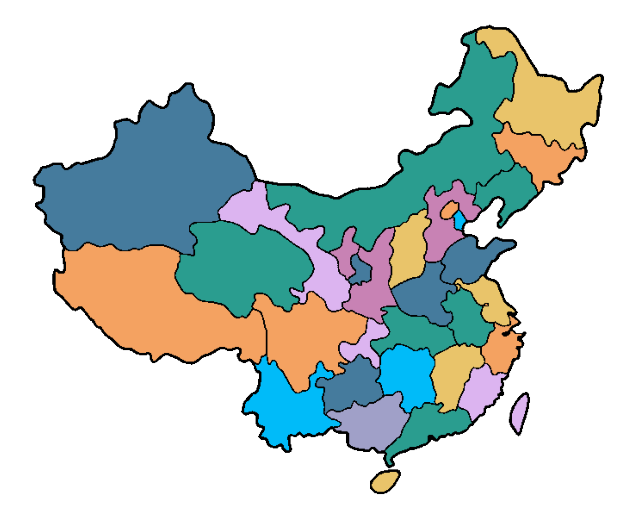

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取并预处理图像
img = cv2.imread('assets/map.png', cv2.IMREAD_GRAYSCALE)
img = 255 - img
img[img <= 150] = 0
img[img > 150] = 255

# 2. 连通域标记
_, binary = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY_INV)
num_labels, labels = cv2.connectedComponents(binary)
print(f"Detected {num_labels-1} regions (excluding background)")

# 3. 定义 8 色调色板（BGR 格式），均为柔和色
color_palette = [
    (180, 130, 200),  # 柔和紫
    (240, 180, 220),  # 柔和粉
    (200, 160, 160),  # 柔和红
    (143, 157, 42),   # 青绿
    (157, 123, 69),   # 深蓝
    (97, 162, 244),   # 暖橙
    (106, 196, 233),  # 柔黄
    (249, 187,   0),  # 亮蓝
]

h, w = labels.shape
rgba = np.zeros((h, w, 4), dtype=np.uint8)

# 4. 给每个连通域上色并设置透明度
for lbl in range(num_labels):
    mask = (labels == lbl)
    if lbl == 1:
        # 标签1视为背景：白色＋全透明
        rgba[..., :3][mask] = (255, 255, 255)
        rgba[..., 3][mask] = 0
        
    elif lbl == 0:
        # 标签1视为背景：白色＋全透明
        rgba[..., :3][mask] = (0, 0, 0)
        rgba[..., 3][mask] = 255
        
    else:
        # 随机挑选一种颜色，不透明
        color = color_palette[np.random.randint(len(color_palette))]
        rgba[..., :3][mask] = color
        rgba[..., 3][mask] = 255

# 5. 保存结果
cv2.imwrite('regions_colored_random.png', rgba)

# 6. 可视化（支持透明度）
plt.figure(figsize=(8, 8))
plt.imshow(rgba[..., [2,1,0,3]])  # BGR->RGB + alpha
plt.axis('off')
# plt.title('Regions Colored with Random Palette & Transparent Background')
plt.show()


In [27]:
import cv2

# 假设 rgba 是一个 uint8、形状为 (H, W, 4) 的数组
cv2.imwrite('regions_transparent.png', rgba)


True

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from skimage import measure
from matplotlib import colors
import cv2
from tqdm import tqdm
import random


def create_adjacency_graph(label_img):
    """
    Create an adjacency graph based on the labeled instance image.
    Each node is a nucleus instance, and edges represent adjacency relationships.
    """
    regions = measure.regionprops(label_img)
    import networkx as nx
    adjacency_graph = nx.Graph()

    # Add nodes for each region
    for region in regions:
        adjacency_graph.add_node(region.label)

    # Add edges: Find all neighboring instances and create edges
    for region in regions:
        coords = region.coords  # Coordinates of the region
        for coord in coords:
            y, x = coord
            # Check adjacent pixels (up, down, left, right)
            for dy, dx in [(-5, 0), (5, 0), (0, -5), (0, 5)]:
                ny, nx = y + dy, x + dx
                if 0 <= ny < label_img.shape[0] and 0 <= nx < label_img.shape[1]:
                    neighbor_label = label_img[ny, nx]
                    if neighbor_label > 0 and neighbor_label != region.label and region.label !=0 and region.label != 1:
                        adjacency_graph.add_edge(region.label, neighbor_label)
    
    return adjacency_graph

def color_cells(label_img):
    """
    Apply the four-color theorem to assign colors to nuclei instances.
    Returns:
      color_index_map: np.array same shape as label_img, values in {1,2,3,4} for labels ≥2
      reassigned_count: number of nodes reassigned because >4 colors were needed
    """
    adjacency_graph = create_adjacency_graph(label_img)

    # Greedy coloring
    coloring = nx.coloring.greedy_color(adjacency_graph, strategy="largest_first")

    # Count and reassign if >4 colors
    if coloring:
        max_color = max(coloring.values())
    else:
        max_color = 0
    reassigned_count = 0

    if max_color >= 4:
        for node, color_index in coloring.items():
            if color_index >= 4:
                coloring[node] = random.randint(0, 3)
                reassigned_count += 1

    # Build per‐pixel color index map
    color_index_map = np.zeros(label_img.shape, dtype=np.uint8)
    for label, color_index in coloring.items():
        color_index_map[label_img == label] = color_index + 1
    return color_index_map, reassigned_count

# ------------------ 主流程 ------------------

# 1. 读取并预处理
img = cv2.imread('assets/map.png', cv2.IMREAD_GRAYSCALE)
img = 255 - img
img[img <= 150] = 0
img[img > 150] = 255

# 2. 二值化 & 连通域标记
_, binary = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY_INV)
num_labels, labels = cv2.connectedComponents(binary)
print(f"Detected {num_labels-1} regions (excluding background)")

# 3. 四色定理着色（仅对标签 ≥2）
color_idx_map, reassigned_count = color_cells(labels)
print(f"Reassigned {reassigned_count} instances to fit 4 colors")

# 4. 定义 4 色调色板（BGR），以及对 0/1 的保留色
palette4 = [
    (143, 157,  42),   # 绿色
    (157, 123,  69),   # 深蓝
    ( 97, 162, 244),   # 暖橙
    (106, 196, 233),   # 柔黄
]

# 5. 构建 RGBA 结果图
h, w = labels.shape
rgba = np.zeros((h, w, 4), dtype=np.uint8)

# 保留 label = 0 (黑色，不透明)
mask0 = (labels == 0)
rgba[mask0, :3] = (  0,   0,   0)
rgba[mask0,  3]   = 255

# 保留 label = 1 (白色，透明)
mask1 = (labels == 1)
rgba[mask1, :3] = (255, 255, 255)
rgba[mask1,  3]   =   0

# 对其余连通域用四色着色
for i, col in enumerate(palette4, start=1):
    mask = (color_idx_map == i)
    rgba[mask, :3] = col
    rgba[mask,  3] = 255

# 6. 保存 & 可视化
cv2.imwrite('regions_4color_theorem.png', rgba)

plt.figure(figsize=(8, 8))
plt.imshow(rgba[..., [2,1,0,3]])  # BGR→RGB + alpha
plt.axis('off')
plt.title('Connected Regions with 4-Color Theorem & Transparent Background')
plt.show()


Detected 34 regions (excluding background)
Reassigned 2 instances to fit 4 colors


IndexError: boolean index did not match indexed array along dimension 0; dimension is 594 but corresponding boolean dimension is 592

In [18]:
np.unique(img)

array([  0, 255], dtype=uint8)

In [34]:
labels

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)